In [1]:
%matplotlib inline
from livelossplot import PlotLossesKeras
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from src import camvid
from src import tiramisu
from src.utils import history_to_results

Using TensorFlow backend.
/usr/local/anaconda5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
!mkdir -p models

##### Note

Because of the skip connections between the down-sampling and up-sampling sides of the network, input image size must be divisible by 32 (2^5). This is because of the max pooling / transpose convolution layers on the down-sampling and up-sampling branch of the network respectively. There are 5 of these units each with 2x2 kernel size and stride 2. Thus, the input must be divisible by 2^5 to ensure the outputs along the down-sampling side of the net can concatenate with the up-sampling side.

In [3]:
# the size of the images in the dataset
target_size = (720, 960)
# the size to crop images to for coarse training
coarse_crop = (224, 224)
# the size to crop images to for fine tune training
fine_crop = (704, 960)

# Coarse Tuning - Train on Random Crops

In [4]:
generators, transformer = camvid.data_generators(target_size=target_size, crop_size=coarse_crop)

Found 491 images belonging to 1 classes.
Found 491 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.


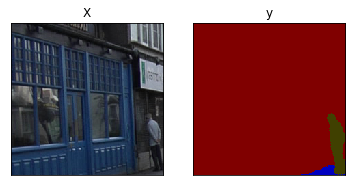

In [5]:
# get the next X, y training tuple
X, y = next(generators['training'])
# transform the onehot vector to an image
y = transformer.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0])

In [6]:
# get the size of the one-hot vectors from the transformer
num_labels = len(transformer)
# build the model for the image shape and number of labels
model = tiramisu.build_tiramisu((*coarse_crop, 3), num_labels,
    label_names=transformer.labels,
    learning_rate=1e-3,
)

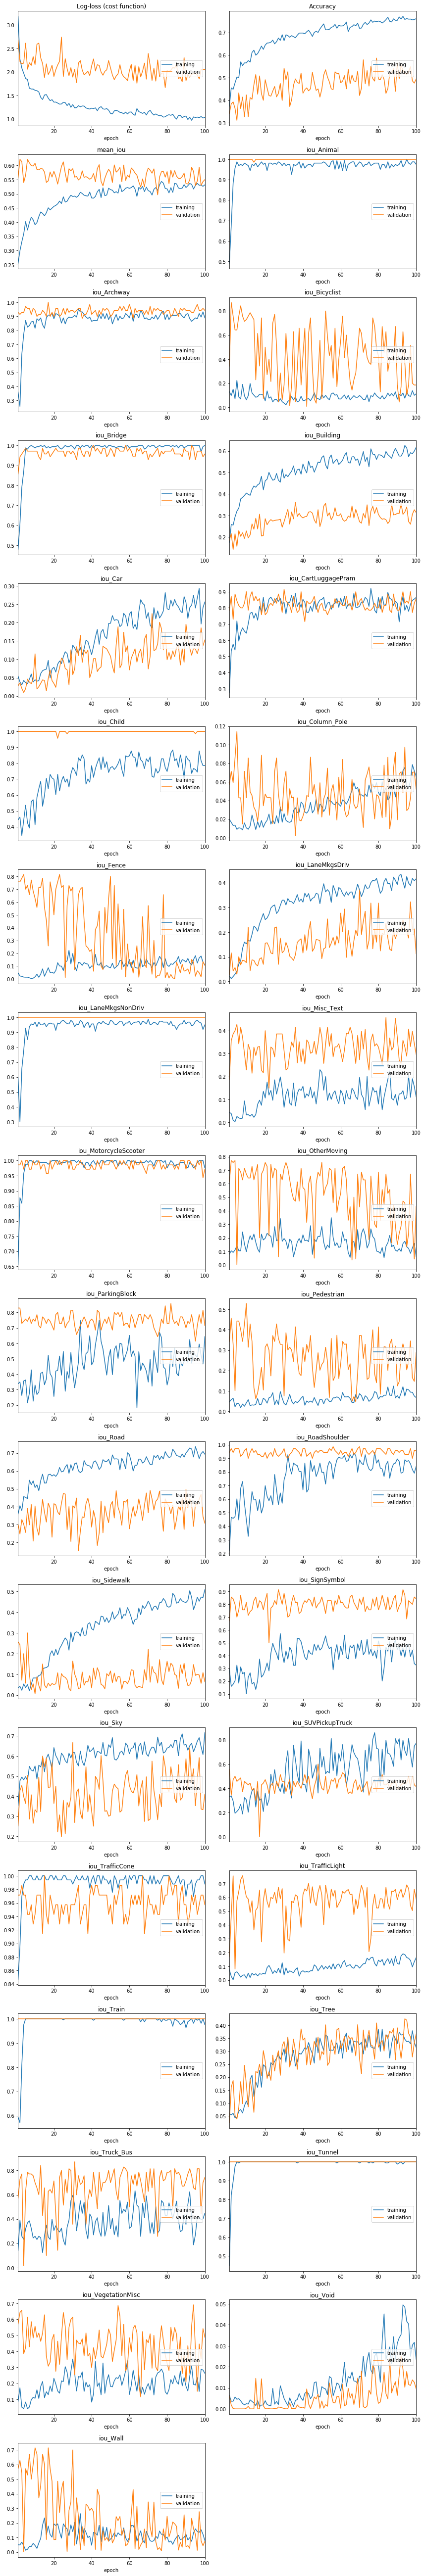

In [7]:
# fit the model with the data. divide the steps per epoch by the 
# batch size (which is 3 in this case)
history = model.fit_generator(generators['training'],
    epochs=100,
    steps_per_epoch=int(491 / 3),
    validation_data=generators['validation'],
    validation_steps=int(210 / 3),
    callbacks=[
        LearningRateScheduler(lambda _, lr: 0.995 * lr),
        EarlyStopping(monitor='val_acc', patience=100),
        PlotLossesKeras(),
    ],
    verbose=0
)

In [8]:
history_to_results(history)

,train,val
acc,0.760879,0.494078
Animal,0.975410,1.000000
Archway,0.889344,0.942857
Bicyclist,0.113073,0.185735
Bridge,1.000000,0.957143
Building,0.617661,0.313628
Car,0.256293,0.152737
CartLuggagePram,0.864754,0.857143
Child,0.784844,1.000000
Column_Pole,0.065878,0.052255


In [9]:
X, y = next(generators['training'])
p = model.predict(X)

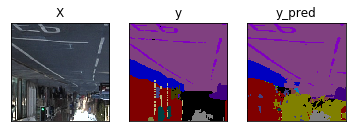

In [10]:
camvid.plot(X=X[0], y=transformer.unmap(y)[0], y_pred=transformer.unmap(p)[0])

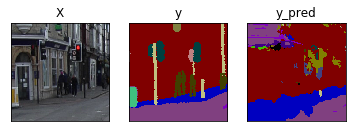

In [11]:
camvid.plot(X=X[1], y=transformer.unmap(y)[1], y_pred=transformer.unmap(p)[1])

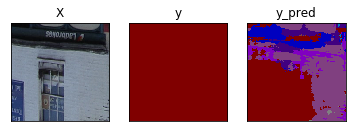

In [12]:
camvid.plot(X=X[2], y=transformer.unmap(y)[2], y_pred=transformer.unmap(p)[2])

In [13]:
X, y = next(generators['validation'])
p = model.predict(X)

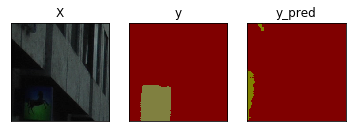

In [14]:
camvid.plot(X=X[0], y=transformer.unmap(y)[0], y_pred=transformer.unmap(p)[0])

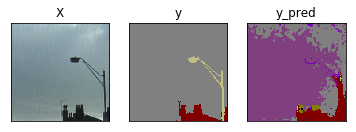

In [15]:
camvid.plot(X=X[1], y=transformer.unmap(y)[1], y_pred=transformer.unmap(p)[1])

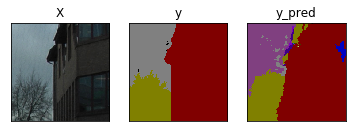

In [16]:
camvid.plot(X=X[2], y=transformer.unmap(y)[2], y_pred=transformer.unmap(p)[2])

## Save Model

In [17]:
# serialize model to JSON
model_json = model.to_json()
with open('models/tiramisu103-coarse.json', 'w') as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights('models/tiramisu103-coarse.h5')

# Fine Tuning - Train on Whole Images

In [18]:
# generators, transformer = camvid.data_generators(target_size=target_size, crop_size=fine_crop)

In [19]:
# # get the next X, y training tuple
# X, y = next(generators['training'])
# # transform the onehot vector to an image
# y = transformer.unmap(y)
# # plot the images
# camvid.plot(X=X[0], y=y[0])

In [20]:
# # # get the size of the one-hot vectors from the transformer
# num_labels = len(transformer)
# # build the model for the image shape and number of labels
# tune_model = tiramisu.build_tiramisu((*fine_crop, 3), num_labels,
#     label_names=transformer.labels,
#     learning_rate=1e-4,
# )
# # load the weights from the coarsely trained model
# tune_model.set_weights(model.get_weights())

In [21]:
# # fit the model with the data. divide the steps per epoch by the 
# # batch size (which is 3 in this case)
# history = tune_model.fit_generator(generators['training'],
#     epochs=250,
#     steps_per_epoch=int(491 / 3),
#     validation_data=generators['validation'],
#     validation_steps=int(210 / 3),
#     callbacks=[
#         LearningRateScheduler(lambda _, lr: 0.995 * lr),
#         EarlyStopping(monitor='val_acc', patience=50),
#         PlotLossesKeras(),
#     ],
#     verbose=0
# )

In [22]:
# X, y = next(generators['validation'])
# p = tune_model.predict(X)

In [23]:
# camvid.plot(X=X[0], y=transformer.unmap(y)[0], y_pred=transformer.unmap(p)[0])

In [24]:
# camvid.plot(X=X[1], y=transformer.unmap(y)[1], y_pred=transformer.unmap(p)[1])

In [25]:
# camvid.plot(X=X[2], y=transformer.unmap(y)[2], y_pred=transformer.unmap(p)[2])

## Save Model

In [26]:
# # serialize model to JSON
# model_json = tune_model.to_json()
# with open('models/tiramisu103-fine.json', 'w') as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# tune_model.save_weights('models/tiramisu103-fine.h5')